In [1]:
import keras
import sklearn.model_selection
import numpy as np


import matplotlib.pyplot as plt

Using TensorFlow backend.


## Create synthetic dataset

Instead of using the actual fingerpint data, this is an example with "fake" fingerprints.
I create these as follows: 
* the fingerprints are 1000 bits long.
* For active molecules, the first 10% of the bits is mostly "on", and the last third is mostly "off".
* for inactive molecules, the opposite: the first 10%% is mostly off and the last mostly on.
* the middle 80% is just noise, on/off are equally probable for both sets.

100 ligands in each set (active and inactive), 200 in total

### Training/validation dataset

In [32]:
fp_len = 1000
meaningul_frac = 0.10

## what is the probability of having an on bit in the meaninful region for actives?
pact=0.65
pinact=1-pact

## how many ligands in each set?
n_act=100
n_inact=100

In [33]:
act=[]
inact=[]

## generate the active
for i in range(n_act):
    odds = np.random.binomial(1,pact,size=int(fp_len*meaningul_frac))
    evens = np.random.binomial(1,1.-pact,size=int(fp_len*meaningul_frac))
    noise = np.random.binomial(1,0.5,size=int(fp_len*(1-2*meaningul_frac)))
    out = np.array([1])
    act.append(np.concatenate((odds,noise,evens,out)))

## generate the inactive
for i in range(n_inact):
    odds = np.random.binomial(1,pinact,size=int(fp_len*meaningul_frac))
    evens = np.random.binomial(1,1.-pinact,size=int(fp_len*meaningul_frac))
    noise = np.random.binomial(1,0.5,size=int(fp_len*(1-2*meaningul_frac)))
    out = np.array([1])
    out = np.array([0])
    inact.append(np.concatenate((odds,noise,evens,out)))

## put them together; x_all are the input for the network, y_all are the output
## which transform to categorical output

data = np.vstack(act+inact)
x_all = data[:,0:-1]
y_all = keras.utils.np_utils.to_categorical(data[:,-1])


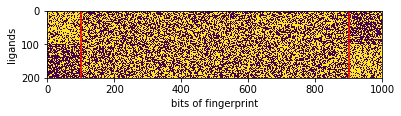

In [34]:
plt.imshow(x_all)
plt.ylabel('ligands')
plt.xlabel('bits of fingerprint')
plt.axvline(x=int(fp_len*meaningul_frac),color='red')
plt.axvline(x=int(fp_len*(1-meaningul_frac)),color='red')


the training/validation set is split randomly in 30% for validation, 70% for training
the validation set is used as follows:


In [35]:
x_train, x_valid, y_train, y_valid = sklearn.model_selection.train_test_split(
    x_all, 
    y_all, 
    test_size=0.3, 
    random_state=0)

### test set
I create a new, independend set using the same definitions as the training to test the predictions of our model.
once the neural network has learned the training set, we use the test set to see how well it works

In [36]:
## geenrate test set:
act=[]
inact=[]

## generate the active
for i in range(n_act):
    odds = np.random.binomial(1,pact,size=int(fp_len*meaningul_frac))
    evens = np.random.binomial(1,1.-pact,size=int(fp_len*meaningul_frac))
    noise = np.random.binomial(1,0.5,size=int(fp_len*(1-2*meaningul_frac)))
    out = np.array([1])
    act.append(np.concatenate((odds,noise,evens,out)))

## generate the inactive
for i in range(n_inact):
    odds = np.random.binomial(1,pinact,size=int(fp_len*meaningul_frac))
    evens = np.random.binomial(1,1.-pinact,size=int(fp_len*meaningul_frac))
    noise = np.random.binomial(1,0.5,size=int(fp_len*(1-2*meaningul_frac)))
    out = np.array([0])
    inact.append(np.concatenate((odds,noise,evens,out)))

## put them together; x_all are the input for the network, y_all are the output
## which transform to categorical output

data_test = np.vstack(act+inact)
x_test = data_test[:,0:-1]
y_test_wanted = data_test[:,-1]


## Define the neural network

In [37]:
model = keras.models.Sequential([
    keras.layers.normalization.BatchNormalization(input_shape=tuple([x_train.shape[1]])),
    keras.layers.core.Dense(32, activation='relu'),
    keras.layers.core.Dense(16, activation='relu'),
    keras.layers.core.Dense(16, activation='relu'),
    keras.layers.core.Dense(2,   activation='sigmoid')
])


#model.compile(
#    loss="categorical_crossentropy", 
#    optimizer="adadelta",
#    metrics=["accuracy"])

model.compile(keras.optimizers.Adam(lr=0.001), 
              loss='categorical_crossentropy', 
              metrics=["accuracy"])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_13 (Batc (None, 1000)              4000      
_________________________________________________________________
dense_25 (Dense)             (None, 32)                32032     
_________________________________________________________________
dense_26 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_27 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_28 (Dense)             (None, 2)                 34        
Total params: 36,866
Trainable params: 34,866
Non-trainable params: 2,000
_________________________________________________________________
None


In [38]:
callback_early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    verbose=0, 
    mode='auto')

## fit the neural network using the test set and the validation set.

In [49]:
model.fit(x_train, y_train, 
          batch_size=100, 
          epochs=200, 
          validation_data=(x_valid, y_valid), 
          verbose=2, 
          callbacks=[])


Train on 140 samples, validate on 60 samples
Epoch 1/200
 - 0s - loss: 3.1710e-04 - acc: 1.0000 - val_loss: 0.0236 - val_acc: 1.0000
Epoch 2/200
 - 0s - loss: 2.8986e-04 - acc: 1.0000 - val_loss: 0.0234 - val_acc: 1.0000
Epoch 3/200
 - 0s - loss: 4.1825e-04 - acc: 1.0000 - val_loss: 0.0232 - val_acc: 1.0000
Epoch 4/200
 - 0s - loss: 2.8706e-04 - acc: 1.0000 - val_loss: 0.0231 - val_acc: 1.0000
Epoch 5/200
 - 0s - loss: 3.1075e-04 - acc: 1.0000 - val_loss: 0.0230 - val_acc: 1.0000
Epoch 6/200
 - 0s - loss: 3.3211e-04 - acc: 1.0000 - val_loss: 0.0229 - val_acc: 1.0000
Epoch 7/200
 - 0s - loss: 2.7067e-04 - acc: 1.0000 - val_loss: 0.0228 - val_acc: 1.0000
Epoch 8/200
 - 0s - loss: 3.0369e-04 - acc: 1.0000 - val_loss: 0.0227 - val_acc: 1.0000
Epoch 9/200
 - 0s - loss: 7.8615e-04 - acc: 1.0000 - val_loss: 0.0224 - val_acc: 1.0000
Epoch 10/200
 - 0s - loss: 2.5842e-04 - acc: 1.0000 - val_loss: 0.0223 - val_acc: 1.0000
Epoch 11/200
 - 0s - loss: 3.1776e-04 - acc: 1.0000 - val_loss: 0.0220 - v

Epoch 93/200
 - 0s - loss: 7.8719e-05 - acc: 1.0000 - val_loss: 0.0150 - val_acc: 1.0000
Epoch 94/200
 - 0s - loss: 8.3706e-05 - acc: 1.0000 - val_loss: 0.0150 - val_acc: 1.0000
Epoch 95/200
 - 0s - loss: 8.3737e-05 - acc: 1.0000 - val_loss: 0.0149 - val_acc: 1.0000
Epoch 96/200
 - 0s - loss: 7.9502e-05 - acc: 1.0000 - val_loss: 0.0149 - val_acc: 1.0000
Epoch 97/200
 - 0s - loss: 2.2958e-04 - acc: 1.0000 - val_loss: 0.0148 - val_acc: 1.0000
Epoch 98/200
 - 0s - loss: 1.0507e-04 - acc: 1.0000 - val_loss: 0.0148 - val_acc: 1.0000
Epoch 99/200
 - 0s - loss: 8.9041e-05 - acc: 1.0000 - val_loss: 0.0147 - val_acc: 1.0000
Epoch 100/200
 - 0s - loss: 8.9843e-05 - acc: 1.0000 - val_loss: 0.0146 - val_acc: 1.0000
Epoch 101/200
 - 0s - loss: 8.5042e-05 - acc: 1.0000 - val_loss: 0.0146 - val_acc: 1.0000
Epoch 102/200
 - 0s - loss: 8.3304e-05 - acc: 1.0000 - val_loss: 0.0146 - val_acc: 1.0000
Epoch 103/200
 - 0s - loss: 1.2345e-04 - acc: 1.0000 - val_loss: 0.0145 - val_acc: 1.0000
Epoch 104/200
 - 

 - 0s - loss: 3.4069e-05 - acc: 1.0000 - val_loss: 0.0113 - val_acc: 1.0000
Epoch 185/200
 - 0s - loss: 3.5030e-05 - acc: 1.0000 - val_loss: 0.0112 - val_acc: 1.0000
Epoch 186/200
 - 0s - loss: 4.1208e-05 - acc: 1.0000 - val_loss: 0.0111 - val_acc: 1.0000
Epoch 187/200
 - 0s - loss: 3.3469e-05 - acc: 1.0000 - val_loss: 0.0111 - val_acc: 1.0000
Epoch 188/200
 - 0s - loss: 3.6846e-05 - acc: 1.0000 - val_loss: 0.0111 - val_acc: 1.0000
Epoch 189/200
 - 0s - loss: 4.0005e-05 - acc: 1.0000 - val_loss: 0.0111 - val_acc: 1.0000
Epoch 190/200
 - 0s - loss: 3.2380e-05 - acc: 1.0000 - val_loss: 0.0111 - val_acc: 1.0000
Epoch 191/200
 - 0s - loss: 3.1353e-05 - acc: 1.0000 - val_loss: 0.0111 - val_acc: 1.0000
Epoch 192/200
 - 0s - loss: 3.3316e-05 - acc: 1.0000 - val_loss: 0.0111 - val_acc: 1.0000
Epoch 193/200
 - 0s - loss: 3.6925e-05 - acc: 1.0000 - val_loss: 0.0110 - val_acc: 1.0000
Epoch 194/200
 - 0s - loss: 3.6457e-05 - acc: 1.0000 - val_loss: 0.0111 - val_acc: 1.0000
Epoch 195/200
 - 0s - lo

## use the network to predict the activity of the ligands in the test set

we now run our network on the test set, and compare its predictions 

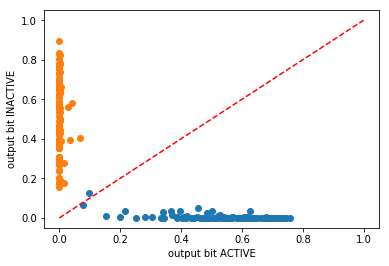

100.0% of the active ligands were correctly identified
 99.0% of the inactive ligands were correctly identified


In [50]:
# Predict test dataset
y_test_predicted = model.predict(x_test)

# plot the results
for gr in [0,1]:
    data_gr = y_test_predicted[y_test_wanted==gr,:]
    plt.plot(data_gr[:,0],data_gr[:,1],marker='o',linewidth=0)
    
plt.xlabel('output bit ACTIVE')
plt.ylabel('output bit INACTIVE')
plt.plot([0,1],[0,1],'--',color='red')
plt.show()

score_1 = ((y_test_predicted[:,1]>y_test_predicted[:,0])[y_test_wanted==1]).mean()
score_0 = ((y_test_predicted[:,1]<y_test_predicted[:,0])[y_test_wanted==0]).mean()
print("%5.1f%% of the active ligands were correctly identified"%(100*score_1))
print("%5.1f%% of the inactive ligands were correctly identified"%(100*score_0))

In [41]:
## fit a second model with normalization and dropout

In [51]:
model2 = keras.models.Sequential([
    keras.layers.normalization.BatchNormalization(input_shape=tuple([x_train.shape[1]])),
    keras.layers.core.Dense(32, activation='relu'),
    keras.layers.core.Dropout(rate=0.5),
    keras.layers.normalization.BatchNormalization(),
    keras.layers.core.Dense(16, activation='relu'),
    keras.layers.core.Dropout(rate=0.5),
    keras.layers.normalization.BatchNormalization(),
    keras.layers.core.Dense(16, activation='relu'),
    keras.layers.core.Dropout(rate=0.5),
    keras.layers.core.Dense(2,   activation='sigmoid')
])

model2.compile(loss="categorical_crossentropy", optimizer="adadelta",metrics=["accuracy"])
print(model2.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_20 (Batc (None, 1000)              4000      
_________________________________________________________________
dense_37 (Dense)             (None, 32)                32032     
_________________________________________________________________
dropout_17 (Dropout)         (None, 32)                0         
_________________________________________________________________
batch_normalization_21 (Batc (None, 32)                128       
_________________________________________________________________
dense_38 (Dense)             (None, 16)                528       
_________________________________________________________________
dropout_18 (Dropout)         (None, 16)                0         
_________________________________________________________________
batch_normalization_22 (Batc (None, 16)                64        
__________

In [52]:
callback_early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    verbose=0, 
    mode='auto')


model2.fit(x_train, y_train, 
          batch_size=100, 
          epochs=200, 
          validation_data=(x_valid, y_valid), 
          verbose=2, 
          callbacks=[callback_early_stopping])


Train on 140 samples, validate on 60 samples
Epoch 1/200
 - 1s - loss: 0.8584 - acc: 0.4500 - val_loss: 0.7144 - val_acc: 0.3500
Epoch 2/200
 - 0s - loss: 0.7700 - acc: 0.5357 - val_loss: 0.7101 - val_acc: 0.5000
Epoch 3/200
 - 0s - loss: 0.7749 - acc: 0.5643 - val_loss: 0.7006 - val_acc: 0.4833
Epoch 4/200
 - 0s - loss: 0.8096 - acc: 0.4857 - val_loss: 0.6880 - val_acc: 0.5000
Epoch 5/200
 - 0s - loss: 0.7554 - acc: 0.4857 - val_loss: 0.6800 - val_acc: 0.5167
Epoch 6/200
 - 0s - loss: 0.7020 - acc: 0.6143 - val_loss: 0.6756 - val_acc: 0.5500
Epoch 7/200
 - 0s - loss: 0.7442 - acc: 0.5000 - val_loss: 0.6637 - val_acc: 0.5833
Epoch 8/200
 - 0s - loss: 0.7567 - acc: 0.5286 - val_loss: 0.6601 - val_acc: 0.6000
Epoch 9/200
 - 0s - loss: 0.7524 - acc: 0.4786 - val_loss: 0.6558 - val_acc: 0.6167
Epoch 10/200
 - 0s - loss: 0.7132 - acc: 0.5857 - val_loss: 0.6451 - val_acc: 0.6833
Epoch 11/200
 - 0s - loss: 0.7015 - acc: 0.5643 - val_loss: 0.6403 - val_acc: 0.7667
Epoch 12/200
 - 0s - loss: 0.

Epoch 97/200
 - 0s - loss: 0.2563 - acc: 0.9143 - val_loss: 0.2057 - val_acc: 1.0000
Epoch 98/200
 - 0s - loss: 0.2926 - acc: 0.8786 - val_loss: 0.2012 - val_acc: 1.0000
Epoch 99/200
 - 0s - loss: 0.2661 - acc: 0.8786 - val_loss: 0.1987 - val_acc: 1.0000
Epoch 100/200
 - 0s - loss: 0.2747 - acc: 0.8714 - val_loss: 0.1941 - val_acc: 1.0000
Epoch 101/200
 - 0s - loss: 0.3049 - acc: 0.8929 - val_loss: 0.1906 - val_acc: 1.0000
Epoch 102/200
 - 0s - loss: 0.3018 - acc: 0.8786 - val_loss: 0.1867 - val_acc: 1.0000
Epoch 103/200
 - 0s - loss: 0.2845 - acc: 0.9000 - val_loss: 0.1832 - val_acc: 1.0000
Epoch 104/200
 - 0s - loss: 0.2659 - acc: 0.9214 - val_loss: 0.1796 - val_acc: 1.0000
Epoch 105/200
 - 0s - loss: 0.2589 - acc: 0.8857 - val_loss: 0.1757 - val_acc: 1.0000
Epoch 106/200
 - 0s - loss: 0.2885 - acc: 0.8857 - val_loss: 0.1723 - val_acc: 1.0000
Epoch 107/200
 - 0s - loss: 0.2107 - acc: 0.9429 - val_loss: 0.1679 - val_acc: 1.0000
Epoch 108/200
 - 0s - loss: 0.2715 - acc: 0.9071 - val_lo

Epoch 193/200
 - 0s - loss: 0.1254 - acc: 0.9429 - val_loss: 0.0314 - val_acc: 1.0000
Epoch 194/200
 - 0s - loss: 0.1316 - acc: 0.9643 - val_loss: 0.0314 - val_acc: 1.0000
Epoch 195/200
 - 0s - loss: 0.1079 - acc: 0.9857 - val_loss: 0.0301 - val_acc: 1.0000
Epoch 196/200
 - 0s - loss: 0.1201 - acc: 0.9643 - val_loss: 0.0297 - val_acc: 1.0000
Epoch 197/200
 - 0s - loss: 0.0967 - acc: 0.9714 - val_loss: 0.0291 - val_acc: 1.0000
Epoch 198/200
 - 0s - loss: 0.0729 - acc: 0.9714 - val_loss: 0.0284 - val_acc: 1.0000
Epoch 199/200
 - 0s - loss: 0.0964 - acc: 0.9786 - val_loss: 0.0273 - val_acc: 1.0000
Epoch 200/200
 - 0s - loss: 0.1470 - acc: 0.9571 - val_loss: 0.0255 - val_acc: 1.0000


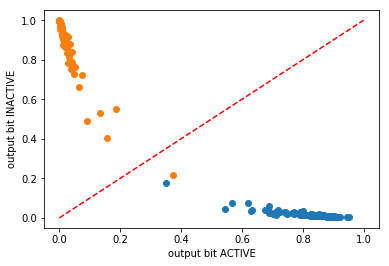

 99.0% of the active ligands were correctly identified
100.0% of the inactive ligands were correctly identified


In [54]:
# Predict test dataset
y_test_predicted = model2.predict(x_test)

# plot the results
for gr in [0,1]:
    data_gr = y_test_predicted[y_test_wanted==gr,:]
    plt.plot(data_gr[:,0],data_gr[:,1],marker='o',linewidth=0)
    
plt.xlabel('output bit ACTIVE')
plt.ylabel('output bit INACTIVE')
plt.plot([0,1],[0,1],'--',color='red')
plt.show()

score_1 = ((y_test_predicted[:,1]>y_test_predicted[:,0])[y_test_wanted==1]).mean()
score_0 = ((y_test_predicted[:,1]<y_test_predicted[:,0])[y_test_wanted==0]).mean()
print("%5.1f%% of the active ligands were correctly identified"%(100*score_1))
print("%5.1f%% of the inactive ligands were correctly identified"%(100*score_0))